<ipython-input-3-e32d40a91484>:100: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(pts.shape[0], radii_scaled.shape[0])
<ipython-input-3-e32d40a91484>:112: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(pts.shape[0], radii_scaled.shape[0])


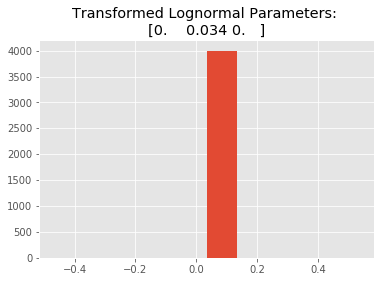

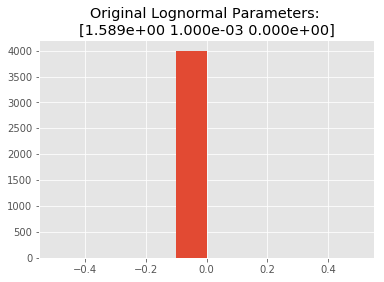

In [3]:


"""
Created on Wed Nov 28 10:19:22 2018

@author: chaztikov
"""

import os,sys
cwd=os.getcwd()
sys.path.append(cwd)
import numpy as np
import scipy
import scipy.stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import run_test_packing
from run_test_packing import *



def porosity_from_radii(radii_scaled, domain_volume,ndimensions = 3):
    pvolumes = radii_scaled**3 * 4 * np.pi / 3 if ndimensions==3 else radii_scaled**2 * np.pi
    porosity = (domain_volume - pvolumes.sum()) / domain_volume
    return porosity,pvolumes

def compute_current_domain_bounding_box(radii_scaled,pts,bbox_vertices):
    radii_scaled.max()













    domain_volume= (xmax-xmin) * (ymax-ymin) * (zmax-zmin)
    porosity,pvolumes = porosity_from_radii(radii_scaled, domain_volume)
    return bbox_vertices, domain_volume, porosity,pvolumes

def compute_correction(x,r,xn,rn):
    if(verbose ==0): print("compute_correction")
    if(verbose ==0): print(xn.shape, x.shape)







    if(verbose ==0): print(x.shape,rn.shape)
    if( xn.shape[0]>1):
        dxn = (xn - x[None,:] ).copy()
        dn = np.linalg.norm( dxn , 2 , axis=1)
        if(verbose ==0): print(dxn.shape,dn.shape)
        if(verbose ==0): print(r)
    else:
        dxn = (xn - x[:] ).copy()
        dn = np.linalg.norm( dxn , 2 , axis=1)
        if(verbose ==0): print(r.shape)
        if(verbose ==0): print(dxn.shape,dn.shape, (r+ rn).shape)

    correct = (rn).copy()

    if(verbose ==0): print(correct.shape)

    xnew = dxn.copy()
    xnew = xnew / dn[:,None]
    if(verbose ==0): print(xnew.shape)
    for i in range(3):
        xnew[:,i] = correct -  dxn[:,i] / dn
    if(verbose ==0): print(dxn.shape)







    xnew = np.mod(xnew,1)




    if(verbose ==0): print("xnew.shape" , xnew.shape)

    return xnew

def overlap_correction(x, r, pts, radii_scaled, RandomState, bbox_vertices,pnorm=2,periodic=1,deltar_min=1.001):
    reinit_flag=0

    if(verbose ==0): print(x.shape)
    if(verbose ==0): print("\n pts.shape \n", pts.shape, radii_scaled.shape)
    assert(pts.shape[0], radii_scaled.shape[0])

    if(pts.shape[0]<2):
        return x, 0

    if(periodic):
        kdt=PeriodicCKDTree(np.array(periodic_bounds), pts)
        icollide = kdt.query_ball_point(x, deltar_min * np.max(r+radii_scaled))
    else:
        if(verbose ==0): print('aperiodic')
        icollide = np.where(((x-pts[:])**2).sum(axis=1) < (radii_scaled[:] + r) * deltar_min  )

    assert(pts.shape[0], radii_scaled.shape[0])


    if(verbose ==0): print(len(icollide))
    if(verbose ==0): print(icollide)



    if(verbose ==0): print("\n icollide \n", icollide , "\n")
    if( len(icollide) > 1 and type(icollide[0])==int ):
        if(verbose ==0): print(pts.shape, radii_scaled.shape)

        reinit_flag = 1
        periodic = 1

        if(periodic):
            if(verbose ==0): print( '\n periodic \n')

            if(verbose ==0): print(x.shape, r, pts.shape, radii_scaled.shape)
            x = compute_correction(x,r,pts[:],radii_scaled[:])
        else:
            x = compute_correction(x,r,pts[:],radii_scaled[:])

        xnew,reinit_flag = overlap_correction(x, r, pts, radii_scaled, RandomState, bbox_vertices, pnorm,periodic)
        
        

    return x, reinit_flag

seed=0
xmax,xmin=1,0
ymax,ymin=1,0
zmax,zmin=1,0
ndimensions=3
verbose=1
radii_dist='lognormal'
radii_dist='uniform'
radius_mu=0.001
radius_sig2=1e-10
tol_self_collision=1e-2
increment_print = int(1e1)
nsamples=int(1e3 * 4) 

percentilemin,percentilemax=10,90

target_porosity=0.35

'''
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
'''




domain_volume= (xmax-xmin) * (ymax-ymin) * (zmax-zmin)
coord_min,coord_max,coord_minmax=np.min((xmin,ymin,zmin)), np.max((xmax,ymax,zmax)),np.min((xmax,ymax,zmax))
RandomState = np.random.RandomState(0)
if(verbose ==0): print(radius_mu)

if(radii_dist=='lognormal'):
    lognormal_sig2 = np.log( radius_sig2 / radius_mu**2 + 1 )
    lognormal_mu = np.log( radius_mu ) - lognormal_sig2 / 2
    radii = RandomState.lognormal( lognormal_mu, lognormal_sig2 ,nsamples)
    radii.mean(),np.std(radii)

    '''truncate sampled distribution'''
    pmin = np.percentile(radii,percentilemin),
    pmax = np.percentile(radii,percentilemax)
    radii = radii[radii<pmax]
    radii = radii[radii>pmin]
    nsamplesclip = nsamples - radii.shape[0]
    nsamples = radii.shape[0]
    

else:
    radii = np.ones([nsamples]) * radius_mu



Z=None
pts=None
rmax=1
dmax=1
rscale=1

'''rescale radii to obtain desired porosity'''
rscale = ( (  np.sum( np.pi * (4./3.) * radii**3) ) / ( domain_volume * (1 - 0.9 * target_porosity) ) )**(1/3)
Z = radii/rscale
radius_mu_scaled = radius_mu / rscale
radius_sig2_scaled = radius_sig2 / rscale**2
rmax = ( Z ).max()
dmax = 2*rmax
















# '''plot original and transformed distributions'''
# plt.hist(Z);
# plt.title( "Transformed Lognormal Parameters: \n" + str( np.round( scipy.stats.lognorm.fit( np.atleast_2d(Z) ), 3) ))
# plt.show()


# plt.hist(radii);
# plt.title( "Original Lognormal Parameters: \n" + str( np.round( scipy.stats.lognorm.fit( np.atleast_2d(radii) ), 3) ))
# plt.show()


do_rescale=1
bbox_vertices = [(xmin,ymin,zmin),(xmax,ymax,zmax)]
periodic_bounds=bbox_vertices[1]

periodic_geometry=True
kdt=None













''' Detect Collisions and Translate Spheres '''
registered = []
unregistered = [i for i in range(nsamples)]
boundary = []
t_list = []
tlast = time.time()
radii_scaled = np.array([])
pts=np.array([])
rands=[]
for i,radius in enumerate(Z):

    r = radius

    pt=np.zeros([3])





    pt[0] = RandomState.uniform(0,xmax)
    pt[1] = RandomState.uniform(0,ymax)
    pt[2] = RandomState.uniform(0,zmax)

    x = pt.copy()
    x = np.atleast_2d(x)


    if(i>0 and i%increment_print==0):
        bbox_vertices, domain_volume, current_porosity, pvolumes = compute_current_domain_bounding_box(radii_scaled, pts, bbox_vertices)
        if(verbose ==0): print("\n Iteration",i,"\n Curr. Sph. Posn. ",x, "\n Sph. Rad.",r,
              "\n time", time.time(), "\n current porosity" , current_porosity,
              "\n bbox_vertices", bbox_vertices, "\n domain_volume" , domain_volume)


    else:
        if(pts.shape[0]>np.inf):
            break;
        else:
            1;
            x,reinit_flag = overlap_correction(x, r, pts, radii_scaled, RandomState, bbox_vertices,2,1)

        if(reinit_flag==1):
            if(periodic_geometry==1):
                break;

        elif(reinit_flag==0):


            registered.append(i)

            if(i>0):
                pts = np.vstack((pts,x))
                radii_scaled = np.hstack((radii_scaled,r))
            else:
                pts = np.array([pt.tolist()])
                radii_scaled = np.array([radius])

            if(verbose ==0): print(pts.shape, radii_scaled.shape)

            try:
                unregistered.remove(i)
            except Exception as e:
                break;
    t_list.append(time.time() - tlast)
    tlast = time.time()





In [4]:

registered=np.array(registered)
domain_volume=xmax*ymax*zmax
bbox_vertices, domain_volume, porosity, pvolumes = compute_current_domain_bounding_box(radii_scaled, pts, bbox_vertices)
save_filename = 'packing'
#save packing output
idx_points = np.arange(0,len(registered)+0)






print("\n domain size ", " [xmin,xmax] ", xmin,xmax, " [ymin,ymax] ", ymin,ymax, " [zmin,zmax] ", zmin,zmax, " volume " , domain_volume)
print('particle volumes: sum, mean, median, min, max', pvolumes.sum(), pvolumes.mean(), np.median(pvolumes) , pvolumes.min(), pvolumes.max())
print("\n \n \n porosity ", porosity)
print("\n number of spheres ", registered.shape)
print("\n number of registered spheres ", registered.shape)
print("\n number of unregistered spheres ", registered.shape )
print("\n sphere distribution parameters ", radius_mu, radius_sig2)
print("\n mean coordination number ", )
print("\n \n \n ")

stacked_data = np.vstack((idx_points.astype(int), pts[:,0], pts[:,1], pts[:,2], radii_scaled[:])).T
np.savetxt(save_filename + ".txt", stacked_data, header="ID x y z r", fmt='%i,%E,%E,%E,%E')
'''
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
'''



import numpy as np

idx,x,y,z,r = np.loadtxt("packing.txt",delimiter=",",skiprows=1,unpack=True)

# Check Porosity
volume = 0.
for i in range(0,len(idx)):
	volume = volume + 4./3.*np.pi*r[i]*r[i]*r[i]
print("check porosity " , 1.-volume)


# # Check Distribution Parameters
# print(np.mean(r))
# print(np.std(r))

#Check Overlap
import sklearn.metrics 
from sklearn.metrics import pairwise_distances as pwdist
pts = np.vstack((x,y,z)).T
dist=pwdist(pts)
row,col=np.where(dist<r[:,None]+r[None,:])
[dist[ri,ci] for ri,ci in zip(row,col) if ri<ci]


# print("Total Number of Overlaps ", count-1)



from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


psize = (pvolumes-pvolumes.min() )
# psize = psize/psize.max()

import plotly


import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

N = 1000
trace = go.Scattergl(
    x = np.random.randn(N),
    y = np.random.randn(N),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
data = [trace]
py.iplot(data, filename='packing_revised.txt',fileopt='new')


 domain size   [xmin,xmax]  0 1  [ymin,ymax]  0 1  [zmin,zmax]  0 1  volume  1
particle volumes: sum, mean, median, min, max 0.6166712499999998 0.00017124999999999993 0.00017124999999999988 0.00017124999999999988 0.00017124999999999988

 
 
 porosity  0.3833287500000002

 number of spheres  (3601,)

 number of registered spheres  (3601,)

 number of unregistered spheres  (3601,)

 sphere distribution parameters  0.001 1e-10

 mean coordination number 

 
 
 


'\n--------------------------------------------------------------------------------------------------------\n--------------------------------------------------------------------------------------------------------\n--------------------------------------------------------------------------------------------------------\n'

check porosity  0.38332876374202496


[0.06231733256823447,
 0.06406552081057146,
 0.053527197673238526,
 0.05511472771047599,
 0.05886972361171763,
 0.06293805743625992,
 0.04134770713764001,
 0.052968170837023314,
 0.05505338718762326,
 0.032469744741065114,
 0.06706873186053473,
 0.050137124465214226,
 0.0683087415239103,
 0.02988567226783307,
 0.05828789631218562,
 0.029311349708603853,
 0.06287704855103991,
 0.029626598062038958,
 0.04741914960445952,
 0.05662904606675143,
 0.06887632496556467,
 0.03486919971622793,
 0.04980374217297779,
 0.0683746954728432,
 0.05378692796692902,
 0.062116701366681945,
 0.045778130959683735,
 0.06071637401586881,
 0.06473097621447825,
 0.05528915512819231,
 0.056303732200623006,
 0.05815260323510459,
 0.04326579925275388,
 0.03812992078329168,
 0.05052577650872701,
 0.050252221176584205,
 0.06186582988371085,
 0.05396735464019286,
 0.060425015984605215,
 0.03283368254186516,
 0.06799303280949043,
 0.010304534575614734,
 0.0663560595300832,
 0.05194457183248739,
 0.061780056146705065,


In [7]:

colors = np.repeat(pvolumes[:,None],3,axis=1)
colors[:,[0,1]]*=0
# pvolumes

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


# psize = ((pvolumes-pvolumes.min()))
# psize = psize/psize.max()
# psize = psize * nsamples
csize = pvolumes

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs=pts[:,0],pts[:,1],pts[:,2]
for xx,yy,zz,ss,cc in zip(xs,ys,zs,psize,colors):
    ax.scatter(xx, yy, zz,s=ss,c=colors,alpha=0.6)
#     ax.scatter(xs, ys, zs,s=psize,c=csize,alpha=0.6)
plt.show()

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3601,4) and requested shape (1,4)

In [ ]:



# # Check Porosity
# volume = 0.
# for i in range(0,len(idx)):seed=0
# xmax,xmin=1,0
# ymax,ymin=1,0
# zmax,zmin=1,0
# ndimensions=3
# radii_dist='lognormal'
# radius_mu=1.
# radius_sig2=0.25
# tol_self_collision=1e-2
# increment_print=int(1e2)
# nsamples=int(1e3 * 2) #expect: far fewer used (until we achieve target porosity within tolerance)

# percentilemin,percentilemax=5,95

# target_porosity=0.4
# volume = volume + 4./3.*np.pi*r[i]*r[i]*r[i]
# print(1.-volume)


# # Check Distribution Parameters
# print(np.mean(r))
# print(np.std(r))


# #Check Overlap
# count = 0 
# for i in range(0,len(idx)):
#     add_to_count=0;
#     for j in range(i+1,len(idx)):
#         distance = np.sqrt( (x[i]-x[j])*(x[i]-x[j]) + (y[i]-y[j])*(y[i]-y[j]) + (z[i]-z[j])*(z[i]-z[j]) )
#         if (distance < (r[i]+r[j])):
#             add_to_count=1
#     count  = count + add_to_count; 
    
# print("Total Number of Overlaps ", count-1)


In [ ]:
plotly.

In [23]:
import plotly


import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

N = 1000
trace = go.Scattergl(
    x = np.random.randn(N),
    y = np.random.randn(N),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
data = [trace]
py.iplot(data, filename='packing_revised.txt',fileopt='new')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


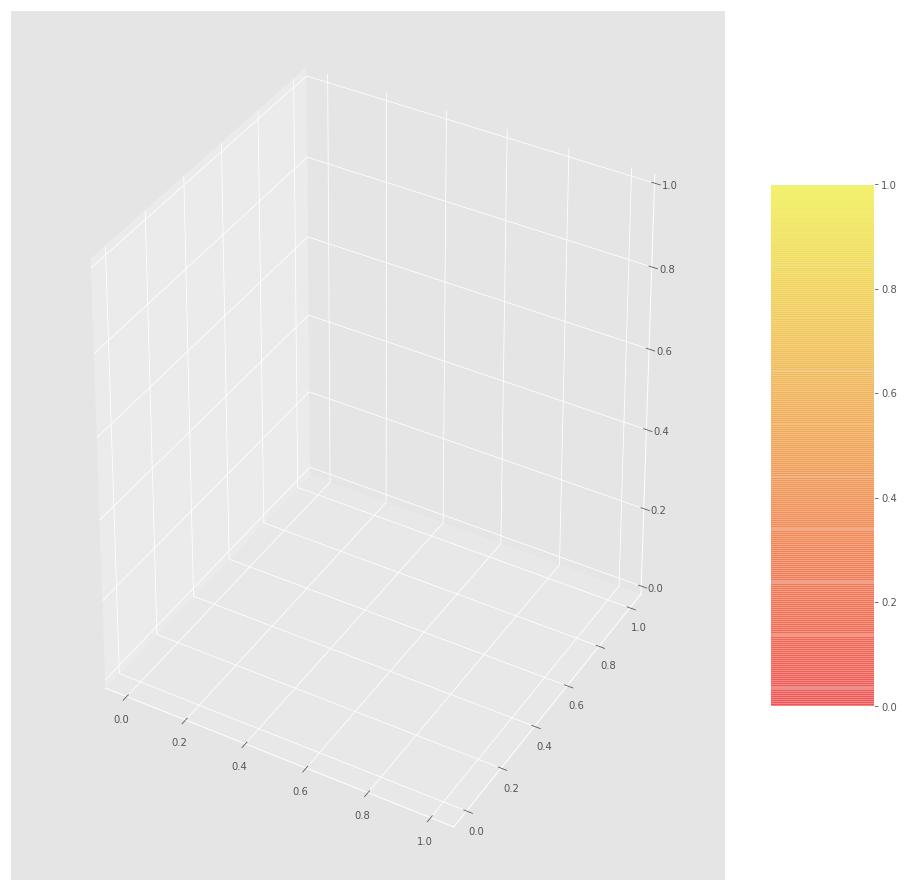

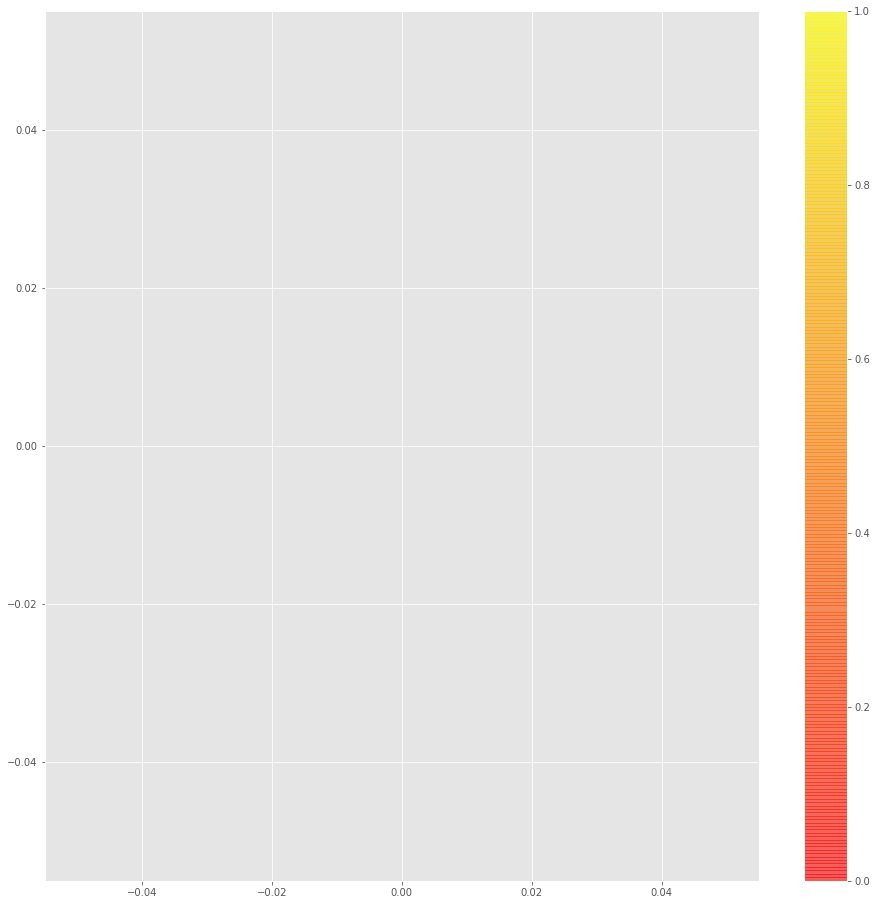

In [9]:
psize = ((pvolumes-pvolumes.min()))
psize = psize/psize.max()
psize = psize * nsamples



fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
X,Y,Z = pts[:,0],pts[:,1],pts[:,2]
cube = ax.scatter(X, Y, Z, zdir='z', s=psize, c=psize,alpha=0.4)
cbar = fig.colorbar(cube, shrink=0.6, aspect=5)
plt.savefig(save_filename+'_3d.png',dpi=200)
# plt.show()



# len(),nsamples
plt.figure(figsize=(16,16))
plt.scatter(pts[:,0],pts[:,1],s=psize,c=psize,alpha=0.6)
plt.colorbar()
plt.savefig(save_filename+'_.png',dpi=200)

In [14]:
pts.max(axis=0),pts.min(axis=0)

(array([0.999978 , 0.999964 , 0.9999566]),
 array([7.369943e-05, 7.244964e-05, 2.069485e-04]))